In [1]:
%%capture

%matplotlib notebook

import time
import sys
import pickle
from threading import Thread
import ipyvolume as ipv
import numpy as np

import ipywidgets as widgets
from IPython.display import display
from IPython.display import display_javascript
from IPython.display import Image
from IPython.display import Javascript
from IPython.utils import io
from matplotlib import pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

sys.path.insert(0, "../examples/arches")
from sample_generator import generate_sample
from calculation import calculation

import swaf
from swaf import CoreSsh as SwafCore
# from swaf import SwafCoreWebService as SwafCore

# queue_state = Queue()
swaf_core = SwafCore(testing=False, server_ip='162.38.54.22',
                     username='brichet', communication_tool='ssh')
swaf_core.set_storage_server('162.38.52.37', '/home/brichet/temp/swaf_data')
# swaf_core = SwafCore(testing=True, communication_tool='socket')

corrections = ""
portee_ark = 0
ark_type_global = None
pointsX_ark = {}
pointsY_ark = {}
points_X = {}
points_Y = {}

def disable_calculation(e):
#     global launch_calcul
    launch_calcul.disabled = True
    
def create_3D_figure(name, coorX, coorY):
    # Close 3D figure if exists... avoid creation of new one
    ipv.pylab.gcc().close()
    fig_temp = ipv.pylab.figure()
    cles = coorX.keys()
    for cle in cles:
        x = coorX[cle]
        y = coorY[cle]
        x_3D = np.array([[x[0], x[1]], [x[3], x[2]]])
        y_3D = np.array([[y[0], y[1]], [y[3], y[2]]])
        ipv.plot_mesh(x_3D, y_3D, np.array([[1,1],[1,1]]), surface=False)

    ipv.show()
    
def fill_axis(axis, coorX, coorY, color='black'):
    cles = coorX.keys()
    for cle in cles:
        xs = coorX[cle]
        ys = coorY[cle]
        axis.plot(xs, ys, color=color)
    
def create_figure(name, coorX, coorY, color='black'):
    global fig_result
    if fig_result is None:
        fig_result = plt.figure("Generated ark : {}".format(name))
    fig_result.clf()
    axis = fig_result.add_subplot(1, 1, 1)
    fill_axis(axis, coorX, coorY)

    axis.set_aspect('equal')
    fig_result.canvas.set_window_title("Generated ark : {}".format(name))
    fig_result.show()

def ark_generation(e):
    global portee_ark, pointsX_ark, pointsY_ark, ark_type_global #, launch_calcul
    
    if ark_type.value == 'Plein cintre' or  ark_type.value == 'Anse de panier':
        if fleche.value > 0.5 * portee.value:
            print('Erreur : fleche de la voute trop importante pour la portee indiquee et pour le type de voute considere') 
            fleche.value = 0.5 * portee.value
    #         DATA['fleche0']=form.fleche.data;form.fleche.default=DATA['fleche0'];print('routes : update default value fleche       = ',form.fleche.default) # 3
        elif fleche.value < 0.2 * portee.value:
            print('Erreur : fleche de la voute trop faible pour la portee indiquee et pour le type de voute considere') 
            fleche.value = 0.2 * portee.value
    #         DATA['fleche0']=form.fleche.data;form.fleche.default=DATA['fleche0'];print('routes : update default value fleche       = ',form.fleche.default) # 3
    elif ark_type.value == 'Parabole':
        if fleche.value < 0.2 * portee.value:
            print('Erreur : fleche de la voute trop faible pour la portee indiquee et pour le type de voute considere') 
            fleche.value = 0.2 * portee.value
    #         DATA['fleche0']=form.fleche.data;form.fleche.default=DATA['fleche0'];print('routes : update default value fleche       = ',form.fleche.default) # 3
    elif ark_type.value == 'Ogive':
        if fleche.value < 0.5 * portee.value:
            print('Erreur : fleche de la voute trop faible pour la portee indiquee et pour le type de voute considere') 
            fleche.value = 0.5 * portee.value
    #         DATA['fleche0']=form.fleche.data;form.fleche.default=DATA['fleche0'];print('routes : update default value fleche       = ',form.fleche.default) # 3
    ark_parameters = {"portee0": portee.value, 
                      "fleche0": fleche.value, 
                      "ep_bandeau0": ep_bandeau.value, 
                      "ep_rein0": ep_rein.value, 
                      "Lc_blocs0": lc_blocs.value, 
                      "bandeau_type0":bandeau_type.value, 
                      "ancrage0": ancrage.value, 
                      "Umas_bloc0": umas_bloc.value, 
                      "Rc_bloc0": rc_bloc.value, 
                      "mortar_type0":mortar_type.value,
                      "lambda_u0": lambda_u.value,
                      "h_remblais0": h_remblais.value,
                      "rho_remblais0": rho_remblais.value}
    
    with io.capture_output() as captured:
        points_X, points_Y = generate_sample(ark_type.value, ark_parameters)
    
    portee_ark = portee.value
    pointsX_ark = points_X
    pointsY_ark = points_Y
    ark_type_global = ark_type.value
    
    
    create_figure(ark_type.value, points_X, points_Y)
    create_3D_figure(ark_type.value, points_X, points_Y)
    
    launch_calcul.disabled = False
    
def execute_calculation(e):
    Q=[]
    if v1.value > 0.1 :
        Q.append((v1.value, e1.value*portee_ark - portee_ark*0.5))
    if v2.value > 0.1 :
        Q.append((v2.value, e2.value*portee_ark - portee_ark*0.5))
    if v3.value > 0.1 :
        Q.append((v3.value, e3.value*portee_ark - portee_ark*0.5))
    load_parameters = {"chargeV1_0": v1.value,
                       "chargeV2_0": v2.value,
                       "chargeV3_0": v3.value,
                       "ecc_e1_0": e1.value,
                       "ecc_e2_0": e2.value,
                       "ecc_e3_0": e3.value,
                       "Q": Q}
    swaf_core.launch_calculation(calculation, load_parameters=load_parameters)
#     print("Address = {}, port = {}".format(swaf_core.communication.remote_address[0], swaf_core.communication.remote_address[1]))
#     if swaf_core.communication is not None:
# #         swaf_core.communication.send_code("import os")
# #         swaf_core.communication.send_code("print(os.listdir())")
# #         swaf_core.communication.send_code("import sys")
# #         swaf_core.communication.send_code("print(sys.modules)")
#         swaf_core.communication.send_code("print(globals())")
#     else:
#         print("socket not set ??")
    monitor_calculation()

def monitor_calculation():
    global fig_result_final, points_X, points_Y
    print("monitoring launched")
    state = "Calculs en cours"
    calculation_state.value = state
    
    while not swaf_core.communication.calculation_over:
#         print(swaf_core.communication.process.ended)
#         try:
#             print(swaf_core.communication.process.stdout.split("\n")[-2])
#         except:
#             print("Rien à afficher")
        if swaf_core.communication.queue_status.empty():
            time.sleep(5)
        else:
            state, progress = swaf_core.communication.queue_status.get()
#             if progress == 2:
#                 print ("sending code")
#                 swaf_core.communication.send_code("print(globals())")
            calculation_state.value = state
            calculation_progress.value = progress
    print("calculation over : {}".format(swaf_core.communication.calculation_over))
    while not swaf_core.communication.queue_status.empty():
        state, progress = swaf_core.communication.queue_status.get()
        calculation_state.value = state
        calculation_progress.value = progress
    
    points_X, points_Y = swaf_core.communication.get_data()
#     points_X, points_Y, bodies = swaf_core.communication.get_data()
    if fig_result_final is None:
        fig_result_final = plt.figure("Calculated ark : {}".format(ark_type_global))
    fig_result_final.clf()
    axis = fig_result_final.add_subplot(1, 1, 1)
    fill_axis(axis, pointsX_ark, pointsY_ark)
    fill_axis(axis, points_X, points_Y, color='red')
    axis.set_aspect('equal')
    fig_result_final.show()
    fig_result_final.canvas.set_window_title("Calculated ark : {}".format(ark_type_global))
    
#     print(bodies)

# Arch 2D description

## Géométrie

In [2]:
ark_type = widgets.RadioButtons(
    options=['PC', 'AP', 'Og', 'Par'],
    value='Og',
    description='Type d\'arche:',
    disabled=False
)
ark_type.observe(disable_calculation, names='value')

portee = widgets.BoundedFloatText(
    value=2.0,
    min=0,
    max=100,
    step=0.1,
    disabled=False,
    description="\t\t",
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='f'
)
portee.observe(disable_calculation, names='value')

fleche = widgets.BoundedFloatText(
    value=1.0,
    min=0,
    max=100,
    step=0.1,
    disabled=False,
    description="\t\t",
    orientation='horizontal',
)
fleche.observe(disable_calculation, names='value')

ep_bandeau = widgets.BoundedFloatText(
    value=0.2,
    min=0,
    max=1,
    step=0.1,
    disabled=False,
    description="\t\t",
    orientation='horizontal',
)
ep_bandeau.observe(disable_calculation, names='value')

ep_rein = widgets.BoundedFloatText(
    value=0.2,
    min=0,
    max=1,
    step=0.1,
    disabled=False,
    description="\t\t",
    orientation='horizontal',
)
ep_rein.observe(disable_calculation, names='value')

lc_blocs = widgets.BoundedFloatText(
    value=0.3,
    min=0,
    max=1,
    step=0.1,
    disabled=False,
    description="\t\t",
    orientation='horizontal',
)
lc_blocs.observe(disable_calculation, names='value')

bandeau_type = widgets.RadioButtons(
    options=['BS', 'H', 'TC'],
    value='BS',
    description='\t',
    disabled=False,
)
bandeau_type.observe(disable_calculation, names='value')

ancrage = widgets.BoundedFloatText(
    value=0.1,
    min=0,
    max=1,
    step=0.1,
    disabled=False,
    description="\t\t",
    orientation='horizontal',
)
ancrage.observe(disable_calculation, names='value')

display(ark_type)
print("\nPortee p (en m) : ")
display(portee)
print("\nFleche f (en m) : ")
display(fleche)
print("\nEpaisseur du bandeau b (en m) : ")
display(ep_bandeau)
print("\nEpaisseur des reins r (en m) : ")
display(ep_rein)
print("\nLongueur caracteristique des blocs lc (en m) :")
display(lc_blocs)
print("\nType de bandeau : ")
display(bandeau_type)
print("\nLongueur d'ancrage du harpage a (en m) :")
display(ancrage)

RadioButtons(description="Type d'arche:", index=2, options=('PC', 'AP', 'Og', 'Par'), value='Og')


Portee p (en m) : 


BoundedFloatText(value=2.0, description='\t\t', step=0.1)


Fleche f (en m) : 


BoundedFloatText(value=1.0, description='\t\t', step=0.1)


Epaisseur du bandeau b (en m) : 


BoundedFloatText(value=0.2, description='\t\t', max=1.0, step=0.1)


Epaisseur des reins r (en m) : 


BoundedFloatText(value=0.2, description='\t\t', max=1.0, step=0.1)


Longueur caracteristique des blocs lc (en m) :


BoundedFloatText(value=0.3, description='\t\t', max=1.0, step=0.1)


Type de bandeau : 


RadioButtons(description='\t', options=('BS', 'H', 'TC'), value='BS')


Longueur d'ancrage du harpage a (en m) :


BoundedFloatText(value=0.1, description='\t\t', max=1.0, step=0.1)

## Matériaux

### Blocs

In [3]:
umas_bloc = widgets.FloatText(
    value=1200.0,
    step=0.1,
    disabled=False,
    description="\t\t",
    orientation='horizontal',
)
umas_bloc.observe(disable_calculation, names='value')

rc_bloc = widgets.FloatText(
    value=53.0,
    step=0.1,
    disabled=False,
    description="\t\t",
    orientation='horizontal',
)
rc_bloc.observe(disable_calculation, names='value')

print("Masse volumique ρb (en kg.m-3) :")
display(umas_bloc)
print("Resistance a la compression Rc (en MPa) :")
display(rc_bloc)


Masse volumique ρb (en kg.m-3) :


FloatText(value=1200.0, description='\t\t', step=0.1)

Resistance a la compression Rc (en MPa) :


FloatText(value=53.0, description='\t\t', step=0.1)

### Mortier

In [4]:
mortar_type = widgets.RadioButtons(
    options=['M0', 'M1', 'M2', 'M3', 'M4'],
    value='M0',
    description='\t',
    disabled=False
)
mortar_type.observe(disable_calculation, names='value')

print("Type de mortier :")
display(mortar_type)


Type de mortier :


RadioButtons(description='\t', options=('M0', 'M1', 'M2', 'M3', 'M4'), value='M0')

## Chargement

### Charges permanentes

In [5]:
lambda_u = widgets.FloatText(
    value=2200.0,
    step=0.1,
    disabled=False,
    description="\t\t",
    orientation='horizontal',
)
lambda_u.observe(disable_calculation, names='value')

h_remblais = widgets.FloatText(
    value=0.3,
    step=0.1,
    disabled=False,
    description="\t\t",
    orientation='horizontal',
)
h_remblais.observe(disable_calculation, names='value')

rho_remblais = widgets.FloatText(
    value=1800.0,
    step=0.1,
    disabled=False,
    description="\t\t",
    orientation='horizontal',
)
rho_remblais.observe(disable_calculation, names='value')

print("Charge surfacique utile λu (en kN/m2) :")
display(lambda_u)
print("Epaisseur remblais hr (en m) :")
display(h_remblais)
print("Charge remblais ρr (en kN/m3) :")
display(rho_remblais)


Charge surfacique utile λu (en kN/m2) :


FloatText(value=2200.0, description='\t\t', step=0.1)

Epaisseur remblais hr (en m) :


FloatText(value=0.3, description='\t\t', step=0.1)

Charge remblais ρr (en kN/m3) :


FloatText(value=1800.0, description='\t\t', step=0.1)

### Charges ponctuelles

In [6]:
v1 = widgets.FloatText(
    value=1000.0,
    step=0.1,
    disabled=False,
    description="\t\t",
    orientation='horizontal',
)

v2 = widgets.FloatText(
    value=2000,
    step=0.1,
    disabled=False,
    description="\t\t",
    orientation='horizontal',
)

v3 = widgets.FloatText(
    value=3000.0,
    step=0.1,
    disabled=False,
    description="\t\t",
    orientation='horizontal',
)

e1 = widgets.FloatText(
    value=0.1,
    step=0.1,
    disabled=False,
    description="\t\t",
    orientation='horizontal',
)

e2 = widgets.FloatText(
    value=0.2,
    step=0.1,
    disabled=False,
    description="\t\t",
    orientation='horizontal',
)

e3 = widgets.FloatText(
    value=0.3,
    step=0.1,
    disabled=False,
    description="\t\t",
    orientation='horizontal',
)

print("Charge ponctuelle V1 (en kN) :")
display(v1)
print("Charge ponctuelle V2 (en kN) :")
display(v2)
print("Charge ponctuelle V3 (en kN) :")
display(v3)
print("Position de la charge V1 : e1 (en m) :")
display(e1)
print("Position de la charge V2 : e2 (en m) :")
display(e2)
print("Position de la charge V3 : e3 (en m) :")
display(e3)


Charge ponctuelle V1 (en kN) :


FloatText(value=1000.0, description='\t\t', step=0.1)

Charge ponctuelle V2 (en kN) :


FloatText(value=2000.0, description='\t\t', step=0.1)

Charge ponctuelle V3 (en kN) :


FloatText(value=3000.0, description='\t\t', step=0.1)

Position de la charge V1 : e1 (en m) :


FloatText(value=0.1, description='\t\t', step=0.1)

Position de la charge V2 : e2 (en m) :


FloatText(value=0.2, description='\t\t', step=0.1)

Position de la charge V3 : e3 (en m) :


FloatText(value=0.3, description='\t\t', step=0.1)

Schéma explicatif des éléments d'une arche : 
![desc_arche](img/description_arches_2D.png)

Button(button_style='success', description="Générer l'arche", style=ButtonStyle(), tooltip='Click me')

<IPython.core.display.Javascript object>


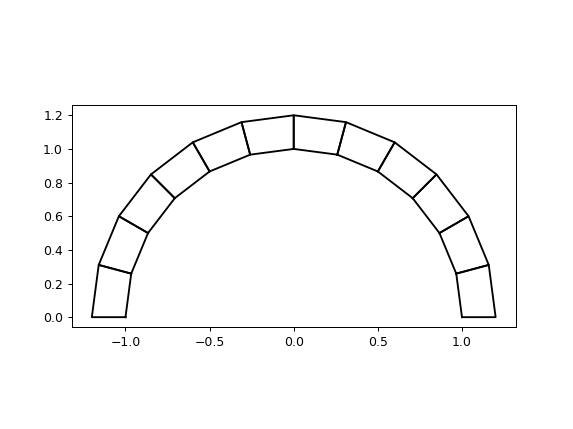

In [7]:
launch_ark = widgets.Button(
    description='Générer l\'arche',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
)
display(launch_ark)
launch_ark.on_click(ark_generation)

fig_result = None


Button(button_style='success', description='Calculs', disabled=True, style=ButtonStyle(), tooltip='Click me')

Label(value='Waiting for calculation...')

IntProgress(value=0)

Remote files removed
files copied
files copied to brichet@162.38.54.22:./arches

Init client
Init client
waiting for the creation of communication file
OK

Process launched : tail -f ./arches/SWAF_REPORT/SWAF_LOG
monitoring launched
INIT/homex/brichet/arches/SWAF_REPORT/SWAF_COM
Waiting for data
Data saved on storage server
Data retrieved
calculation over : True


<IPython.core.display.Javascript object>


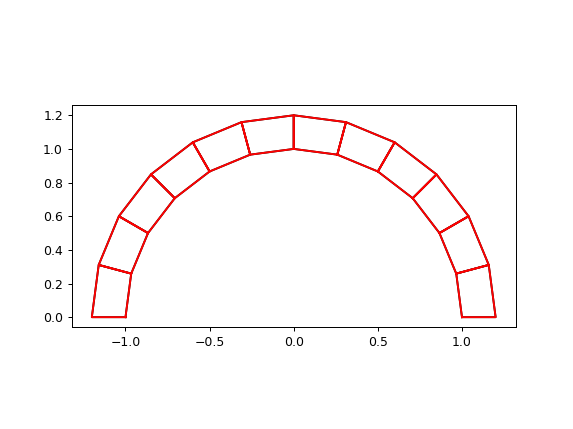

In [8]:
launch_calcul = widgets.Button(
    description='Calculs',
    disabled=True,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
)
display(launch_calcul)
launch_calcul.on_click(execute_calculation)

calculation_state = widgets.Label(value="Waiting for calculation...")
display(calculation_state)

calculation_progress = widgets.IntProgress(
    value=0,
    min=0,
    max=100,
)
display(calculation_progress)

fig_result_final = None
